# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


c:\programdata\anaconda3\envs\sagar\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\envs\sagar\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\envs\sagar\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programdata\anaconda3\envs\sagar\lib\site-packages\tensorflow\python\f

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'inference_graph_mask_rcnn'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'labelmap.pbtxt')

## Download Model

In [5]:
'''opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())'''

"opener = urllib.request.URLopener()\nopener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)\ntar_file = tarfile.open(MODEL_FILE)\nfor file in tar_file.getmembers():\n  file_name = os.path.basename(file.name)\n  if 'frozen_inference_graph.pb' in file_name:\n    tar_file.extract(file, os.getcwd())"

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [11]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open("1.JPG")
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=0,
      skip_labels=False,
      skip_scores=True)
      
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.savefig("jupyter.jpg")  
    

Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
import cv2
import numpy as np
img = cv2.imread('jupyter.jpg')
height = img.shape[0]
width = img.shape[1]
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
cv2.imshow("detection_masks", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()
count = cv2.countNonZero(thresh)
area = count*0.8*0.8/(width*height)
print(area)


In [23]:
print(image_np)

[[[  0 255 255]
  [127 255   0]
  [127 255   0]
  ...
  [127 255   0]
  [127 255   0]
  [ 73  85  63]]

 [[  0 255 255]
  [127 255   0]
  [  0 255 255]
  ...
  [ 73  86  60]
  [127 255   0]
  [ 58  70  46]]

 [[  0 255 255]
  [127 255   0]
  [  0 255 255]
  ...
  [ 90 103  73]
  [127 255   0]
  [ 52  65  37]]

 ...

 [[ 81  77  66]
  [ 81  77  66]
  [ 84  77  67]
  ...
  [107  95  83]
  [112 100  88]
  [109  97  85]]

 [[ 84  80  71]
  [ 82  78  69]
  [ 76  69  61]
  ...
  [111  98  89]
  [120 107  98]
  [113 100  91]]

 [[ 85  81  72]
  [ 88  84  75]
  [ 85  78  70]
  ...
  [104  91  82]
  [110  97  88]
  [105  92  83]]]


In [20]:
label_image=output_dict['detection_classes']
print(label_image)


[1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 3 2 1 1 3 3 1 2 3 1 1 3 1 3 3 3 2 3 3 3 3
 3 3 1 4 2 3 3 3 3 2 2 4 2 4 3 3 2 3 2 1 1 1 3 3 2 2 3 3 1 4 2 4 3 3 2 3 4
 3 4 4 2 3 2 4 4 4 3 4 4 3 4 1 2 3 2 1 2 3 2 2 4 4 4 1 4 3 1 3 4 4 4 2 3 4
 2 2 4 4 4 4 3 2 3 4 3 3 2 3 4 2 4 4 4 2 2 3 2 3 3 2 2 1 4 4 1 3 3 2 2 4 2
 4 2 1 3 3 4 3 1 2 3 3 1 4 4 4 1 4 4 3 2 3 4 3 4 2 4 1 2 1 3 3 4 2 3 2 4 2
 2 3 1 3 2 3 4 3 2 2 3 2 2 3 3 2 2 4 4 1 2 4 2 4 2 3 3 4 4 3 4 4 3 3 4 3 4
 1 3 2 3 3 2 1 4 3 4 3 3 1 3 3 3 3 3 3 2 4 4 3 4 4 4 3 3 2 2 2 4 3 3 2 4 4
 3 3 3 3 3 2 4 2 3 4 2 2 2 1 3 3 4 4 4 2 3 3 3 4 2 2 2 3 4 4 1 1 2 4 4 4 2
 1 2 2 4]


In [28]:
from skimage import measure, io, img_as_ubyte
import matplotlib.pyplot as plt
from skimage.color import label2rgb, rgb2gray
import numpy as np

# The input image.
image = img_as_ubyte(rgb2gray(io.imread("jupyter.jpg")))

plt.imshow(image)
scale = 0.6 #microns/pixel

#plt.hist(blue_channel.flat, bins=100, range=(0,150))  #.flat returns the flattened numpy array (1D)

"""from skimage.filters import threshold_otsu
threshold = threshold_otsu(image)

#Generate thresholded image
thresholded_img = image < threshold
plt.imshow(thresholded_img)

#Remove edge touching regions
from skimage.segmentation import clear_border
edge_touching_removed = clear_border(thresholded_img)
plt.imshow(edge_touching_removed)

#Label connected regions of an integer array using measure.label
#Labels each connected entity as one object
#Connectivity = Maximum number of orthogonal hops to consider a pixel/voxel as a neighbor.
#If None, a full connectivity of input.ndim is used, number of dimensions of the image
#For 2D image it would be 2
"""
#label_image = measure.label(edge_touching_removed, connectivity=image.ndim)

#plt.imshow(label_image)
#Return an RGB image where color-coded labels are painted over the image.
#Using label2rgb

#image_label_overlay = (label_image, image=image)
#plt.imshow(image_label_overlay)

#plt.imsave("labeled_cast_iron.jpg", image_label_overlay)

#################################################
#Calculate properties
#Using regionprops or regionprops_table
all_props=measure.regionprops(label_image, image)
#Can print various parameters for all objects
for prop in all_props:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

#Compute image properties and return them as a pandas-compatible table.
#Available regionprops: area, bbox, centroid, convex_area, coords, eccentricity,
# equivalent diameter, euler number, label, intensity image, major axis length,
#max intensity, mean intensity, moments, orientation, perimeter, solidity, and many more

props = measure.regionprops_table(label_image, image,
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])

import pandas as pd
df = pd.DataFrame(props)
print(df.head())

#To delete small regions...
df = df[df['area'] > 50]
print(df.head())

#######################################################
#Convert to micron scale
df['area_sq_microns'] = df['area'] * (scale**2)
df['equivalent_diameter_microns'] = df['equivalent_diameter'] * (scale)
print(df.head())

df.to_csv('cast_iron_measurements.csv')

TypeError: Only 2-D and 3-D images supported.

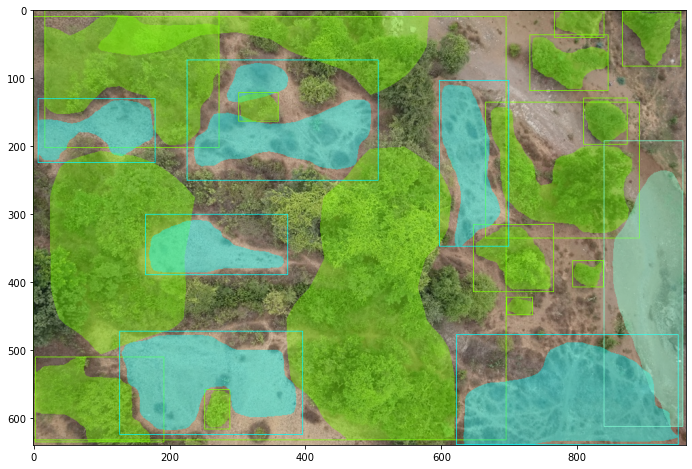

In [12]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.imshow(image_np)